In [16]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.datasets import load_breast_cancer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [17]:
# 归一化预处理
class Normalizer:
    def __init__(self, dataframe):
        """
        初始化类，接收一个DataFrame作为输入。
        """
        self.dataframe = dataframe
        self.scaler = MinMaxScaler()
        self.normalized_data = None
        self.scaler_params = None

    def get_normalization_params(self):
        """
        获取归一化参数（基于MinMaxScaler）。
        """
        # 拟合数据以获取归一化参数
        self.scaler.fit(self.dataframe)
        
        # 保存归一化参数
        self.scaler_params = {
            'data_min': self.scaler.data_min_,
            'data_max': self.scaler.data_max_
        }
        return self.scaler_params

    def preprocess(self, otherdata=None):
        """
        对数据进行归一化处理。
        使用类中的归一化参数，如果参数为空则抛出提示。

        参数:
        - otherdata: 可选参数，指定需要归一化的数据。如果未提供，则默认使用类中的dataframe。
        """
        if self.scaler_params is None:
            raise ValueError("归一化参数为空！请先调用 `get_normalization_params` 方法获取归一化参数。")
        
        # 如果未提供otherdata，则使用类中的dataframe
        if otherdata is None:
            otherdata = self.dataframe
        
        # 使用类中的归一化参数进行归一化
        data_min = self.scaler_params['data_min']
        data_max = self.scaler_params['data_max']
        normalized_data = (otherdata - data_min) / (data_max - data_min)
        
        # 将归一化后的数据转换回DataFrame
        normalized_df = pd.DataFrame(normalized_data, columns=otherdata.columns)
        return normalized_df

# 从 CSV 文件中读取数据并转换为 DataFrame
df_drop = pd.read_csv('df_drop.csv')
df = pd.read_csv('df.csv')

### 随机森林

In [18]:
# 随机森林模型部分默认参数
'''
rf = RandomForestClassifier(
    n_estimators=100,           # 树的数量
    max_depth=None,              # 树的最大深度
    min_samples_leaf=1,        # 叶节点所需的最小样本数
    min_samples_split=2,       # 分裂内部节点所需的最小样本数
    max_features='auto',       # 寻找最佳分裂时考虑的特征数量
    criterion='gini',          # 分裂标准

    random_state=68,           # 随机种子
    n_jobs=-1                  # 使用所有 CPU 核心
)
'''

"\nrf = RandomForestClassifier(\n    n_estimators=100,           # 树的数量\n    max_depth=None,              # 树的最大深度\n    min_samples_leaf=1,        # 叶节点所需的最小样本数\n    min_samples_split=2,       # 分裂内部节点所需的最小样本数\n    max_features='auto',       # 寻找最佳分裂时考虑的特征数量\n    criterion='gini',          # 分裂标准\n\n    random_state=68,           # 随机种子\n    n_jobs=-1                  # 使用所有 CPU 核心\n)\n"

In [19]:
data = df_drop
df_X = df_drop.drop('Attrition', axis=1)
df_Y = df_drop['Attrition']

# 固定训练集和测试集的划分
xtrain, xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.3, random_state=68)

# Normalizer 是自定义归一化类
normalize2 = Normalizer(xtrain)
normalize2.get_normalization_params()
xtrain = normalize2.preprocess()
xtest = normalize2.preprocess(xtest)

# 对训练集进行 SMOTE 过采样
smote = SMOTE(random_state=68)
xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

# 初始化随机森林模型，固定随机种子
rf = RandomForestClassifier(
    n_estimators=151,           # 树的数量

    max_depth=None,              # 树的最大深度
    min_samples_leaf=1,        # 叶节点所需的最小样本数
    min_samples_split=2,       # 分裂内部节点所需的最小样本数
    max_features='auto',       # 寻找最佳分裂时考虑的特征数量
    criterion='gini',          # 分裂标准

    random_state=68,           # 随机种子
    n_jobs=-1                  # 使用所有 CPU 核心
)

# 训练模型
rf.fit(xtrain_resampled, ytrain_resampled)

# 在测试集上评估模型
score = rf.score(xtest, ytest)

# 在训练集上进行交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=68)
cross_s = cross_val_score(rf, xtrain_resampled, ytrain_resampled, cv=kf).mean()

# 输出结果
print('测试集准确率:', score)
print('交叉验证平均准确率:', cross_s)

测试集准确率: 0.9030303030303031
交叉验证平均准确率: 0.933274664196387


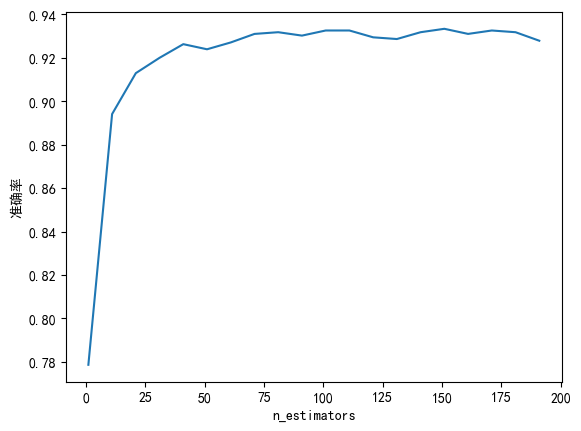

最佳 n_estimators: 151, 最高准确率: 0.9333


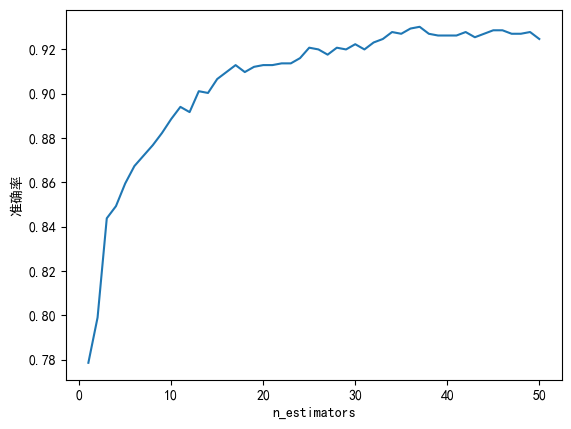

最佳 n_estimators: 37, 最高准确率: 0.9301


In [20]:
### n_estimators 调参 ###
data = df_drop
df_X = df_drop.drop('Attrition', axis=1)
df_Y = df_drop['Attrition']

# 固定训练集和测试集的划分
xtrain, xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.3, random_state=68)

# 假设 Normalizer 是你的自定义归一化类
normalize2 = Normalizer(xtrain)
normalize2.get_normalization_params()
xtrain = normalize2.preprocess()
xtest = normalize2.preprocess(xtest)

# 使用 SMOTE 进行过采样
smote = SMOTE(random_state=68)
xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

# 固定交叉验证的随机种子
kf = KFold(n_splits=5, shuffle=True, random_state=68)

# 调参第一步：n_estimators
cross = []
for i in range(0, 200, 10):
    rf = RandomForestClassifier(n_estimators=i + 1, n_jobs=-1, random_state=68)
    cross_score = cross_val_score(rf, xtrain_resampled, ytrain_resampled, cv=kf).mean()
    cross.append(cross_score)

# 中文环境
matplotlib.rcParams['font.sans-serif']=['SimHei'] 

# 绘制 n_estimators 的调参结果
plt.plot(range(1, 201, 10), cross)
plt.xlabel('n_estimators')
plt.ylabel('准确率')
plt.show()

# 输出最佳 n_estimators 和对应的准确率
best_n_estimators = (cross.index(max(cross)) * 10) + 1
best_acc = max(cross)
print(f"最佳 n_estimators: {best_n_estimators}, 最高准确率: {best_acc:.4f}")

# n_estimators 缩小范围
cross = []
for i in range(0, 50):
    rf = RandomForestClassifier(n_estimators=i + 1, n_jobs=-1, random_state=68)
    cross_score = cross_val_score(rf, xtrain_resampled, ytrain_resampled, cv=kf).mean()
    cross.append(cross_score)

# 绘制缩小范围后的 n_estimators 调参结果
plt.plot(range(1, 51), cross)
plt.xlabel('n_estimators')
plt.ylabel('准确率')
plt.show()

# 输出最佳 n_estimators 和对应的准确率
best_n_estimators = cross.index(max(cross)) + 1
best_acc = max(cross)
print(f"最佳 n_estimators: {best_n_estimators}, 最高准确率: {best_acc:.4f}")

In [21]:
### 剩余参数调参（可选） ###

# 固定交叉验证的随机种子
kf = KFold(n_splits=5, shuffle=True, random_state=68)

# 初始化随机森林模型
rf = RandomForestClassifier(n_estimators=37, random_state=68)

# 创建包含 SMOTE 和随机森林的 Pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=68)),  # SMOTE 过采样
    ('rf', rf)  # 随机森林模型
])

# 定义调参步骤（按照指定顺序）
param_grids = [
    {'rf__max_depth': np.arange(1, 31, 1)},  # 调整 max_depth
    {'rf__min_samples_leaf': np.arange(1, 51, 1)},  # 调整 min_samples_leaf
    {'rf__min_samples_split': np.arange(2, 52, 1)},  # 调整 min_samples_split
    {'rf__max_features': np.arange(2, 35, 1)},  # 调整 max_features
    {'rf__criterion': ['gini', 'entropy']}  # 调整 criterion
]

# 初始化最佳参数
best_params = {}

# 遍历每个参数网格进行调参
for param_grid in param_grids:
    # 将当前最佳参数应用到模型中
    pipeline.set_params(**best_params)
    
    # 使用 GridSearchCV 进行调参
    GS = GridSearchCV(pipeline, param_grid, cv=kf, n_jobs=-1)
    GS.fit(df_X, df_Y)
    
    # 更新最佳参数
    best_params.update(GS.best_params_)
    
    # 输出当前调参结果
    print("当前调参:", param_grid)
    print("最佳参数:", GS.best_params_)
    print("最佳得分:", GS.best_score_)
    print("-" * 50)

# 输出最终的最佳参数
print("最终最佳参数:", best_params)

当前调参: {'rf__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}
最佳参数: {'rf__max_depth': 13}
最佳得分: 0.8781818181818182
--------------------------------------------------
当前调参: {'rf__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}
最佳参数: {'rf__min_samples_leaf': 11}
最佳得分: 0.8818181818181818
--------------------------------------------------
当前调参: {'rf__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])}
最佳参数: {'rf__min_samples_split': 2}
最佳得分: 0.8818181818181818
--------------------------------------------------
当前调参: